In [4]:
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # p(f)

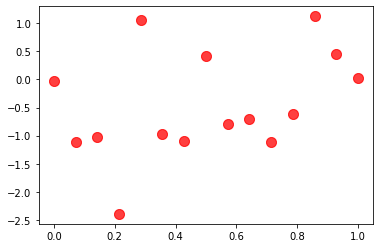

In [9]:
### Prepare data

# x = torch.linspace(0., 1., 200)
x = np.linspace(0., 1., 15)
np.random.shuffle(x)
x = torch.from_numpy(x).float()

RBF_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
gp = ExactGPModel(
    train_x=None,
    train_y=None,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(), # p(y|f)
    kernel=RBF_kernel
)

true_lengthscale = 0.05
true_noise = 0.5
gp.covar_module.base_kernel.lengthscale = true_lengthscale
gp.eval()
f_preds = gp(x) 
y = f_preds.rsample().detach() + true_noise * torch.randn(len(x))
plt.plot(x, y, "ro", ms=10, alpha=0.5)

test_x = torch.linspace(0., 1., 100)

plt.plot(x, y, "ro", ms=10, alpha=0.5)

In [87]:
RBF_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
RBF_kernel.base_kernel.lengthscale = 0.05
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = 0.1
# likelihood.noise_covar.noise = 1.

gp = ExactGPModel(
    train_x=x,
    train_y=y,
    likelihood=likelihood,
    kernel=RBF_kernel
)


In [88]:
test_x.shape

torch.Size([100])

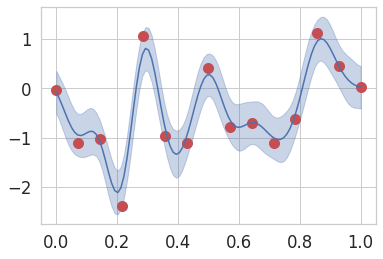

In [89]:
gp.eval()
likelihood.eval()

f_preds = gp(test_x)
# f_samples = f_preds.rsample(sample_shape=torch.Size([100]))
y_preds = likelihood(f_preds)
y_preds

mu = y_preds.mean.detach().numpy()
sigma = y_preds.stddev.detach().numpy()

# for sample in f_samples.detach():
#     plt.plot(test_x, sample, color="b", alpha=0.3)
plt.plot(x, y, "ro", ms=10)
plt.plot(test_x, mu)
plt.fill_between(test_x.detach().numpy(), mu-sigma, mu+sigma, color="b", alpha=0.3)

In [90]:
# np.savez("gp_lowsigma.npz",
#         x=x, y=y, x_test=test_x.detach().numpy(), mu=mu, sigma=sigma)

# np.savez("gp_highsigma.npz",
#         x=x, y=y, x_test=test_x.detach().numpy(), mu=mu, sigma=sigma)

## Plots

In [91]:
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')

In [128]:
def get_color(*arr):
    return [c / 255 for c in arr]

orange = get_color(255, 127, 42) #+ [0.7]
darkblue = get_color(0, 51, 128)
red = get_color(212, 0, 0)
purple = get_color(175, 55, 200)
lightgrey = get_color(250, 250, 250)

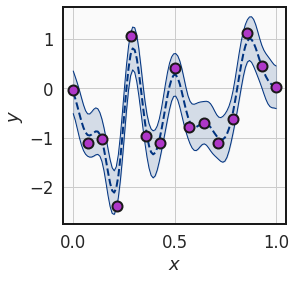

In [130]:
arr = np.load("gp_lowsigma.npz")

f = plt.figure(figsize=(4, 4))
plt.plot(arr["x_test"], arr["mu"], "--", color=darkblue, lw=2)
plt.fill_between(arr["x_test"], arr["mu"]-arr["sigma"], arr["mu"]+arr["sigma"], color=darkblue, alpha=0.15)
plt.plot(arr["x_test"], arr["mu"]-arr["sigma"], "-", color=darkblue, lw=1)
plt.plot(arr["x_test"], arr["mu"]+arr["sigma"], "-", color=darkblue, lw=1)
plt.plot(arr["x"], arr["y"], "o", color=purple, ms=10, markeredgecolor="k", mew=2)
plt.xlabel("$x$")
plt.ylabel("$y$")

ax = f.get_axes()[0]
ax.set_facecolor(lightgrey)
[spine.set_color("k") for spine in ax.spines.values()]
[spine.set_linewidth(2) for spine in ax.spines.values()]
plt.savefig("../../Papers/data_aug_bnns/arxiv/figures/intro_gp_lowsigma.pdf", bbox_inches="tight")

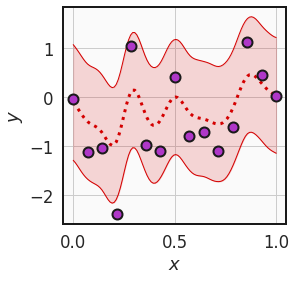

In [131]:
arr = np.load("gp_highsigma.npz")

f = plt.figure(figsize=(4, 4))
plt.plot(arr["x_test"], arr["mu"], ":", color=red, lw=3)
# plt.plot(arr["x_test"], arr["mu"], "-", color=red, lw=1)
plt.fill_between(arr["x_test"], arr["mu"]-arr["sigma"], arr["mu"]+arr["sigma"], color=red, alpha=0.15)
plt.plot(arr["x_test"], arr["mu"]-arr["sigma"], "-", color=red, lw=1)
plt.plot(arr["x_test"], arr["mu"]+arr["sigma"], "-", color=red, lw=1)
plt.plot(arr["x"], arr["y"], "o", color=purple, ms=10, markeredgecolor="k", mew=2)
plt.xlabel("$x$")
plt.ylabel("$y$")

ax = f.get_axes()[0]
ax.set_facecolor(lightgrey)
[spine.set_color("k") for spine in ax.spines.values()]
[spine.set_linewidth(2) for spine in ax.spines.values()]
plt.savefig("../../Papers/data_aug_bnns/arxiv/figures/intro_gp_highsigma.pdf", bbox_inches="tight")